In [ ]:
import qcodes as qc
import numpy as np
from time import sleep

import sweep 
from barreralabdrivers.utils.param_utils import paramp
from cappy.config import coolconfig, datapath
from cappy.balancer import Balancer

from qcodes.validators import Numbers

In [3]:
# instrument connections 
qc.Instrument.close_all()   # in case of existing connecitons
container = qc.Station(config_file=str(coolconfig))

acdac = container.load_instrument("acdac")
yoko = container.load_instrument("yoko")
keithley = container.load_instrument("keithley")
li1 = container.load_instrument("lockin1")
li2 = container.load_instrument("lockin2")
# ppms = container.load_instrument("ppms") # update PPMS PC ethernet IP address to 169.254.x.x 

Connected to: BARRERA ACDAC02 (serial:AD9106, firmware:2.00) in 3.05s
Connected to: YOKOGAWA 765611 (serial:90ZC43353, firmware:1.10) in 0.02s
Connected to: KEITHLEY INSTRUMENTS DMM6500 (serial:04608216, firmware:1.7.12b) in 0.01s
Connected to: Stanford_Research_Systems SR865A (serial:005296, firmware:V1.51) in 0.10s
Connected to: Stanford_Research_Systems SR860 (serial:005276, firmware:V1.51) in 0.07s


In [ ]:
# TODO: aliases for parameters. Update labels to reflect physical quantities for following cell

vg = yoko.channel2.voltage
vg.label = "Vg"
neg_val = Numbers(min_value=-2, max_value=0)
vg.add_validator(neg_val)                       # never allow positive values on Vg 


vdd = yoko.channel1.voltage 
vdd.label = "Vdd"

vds = keithley.amplitude
vds.label = "Vds"

Vexc = acdac.ch1
Vref = acdac.ch2

Gout = li1
Vtherm = li2.X


indep_params = [vg]
dep_params = [vds, Gout.R, Gout.P]

In [ ]:
# class LI_Temp():
#     def __init__(self, lockin):
#         self.full_name = "temp"
#         self._voltage = lockin.X

#     def get(self):
#         TODO: update with getting function
#         return self._voltage()
    
#     def set(self, val):
#         # TODO: update with setting function
    
#     __call__ = get

# therm = LI_Temp(li1)
# print(therm())

In [5]:
Vexc.voltage(100)
Vref.voltage(0)
acdac.ch4.voltage(400)

In [ ]:
balancer.excite(DRIVE, 400, FREQ)

In [11]:
# measurement config for analysis 
mc = {}
for param in indep_params + dep_params:
    mc[param.full_name] = param.label

s = sweep.Station(basedir=datapath, measurement_config=mc)
for param in indep_params + dep_params:
    s.fp(param)

s.add_comment("Vg sweep")

In [ ]:
# instrument setup

In [12]:
# TODO: add parameters to live plot here 

for dep in dep_params:
    s.plot(vg, dep)

2024-11-25 21:28:38,165 [INFO] Starting sweep with ID 0
2024-11-25 21:28:38,166 [INFO] Minimum duration 0h 0m 40s


  0%|          | 0/100 [00:00<?, ?it/s]

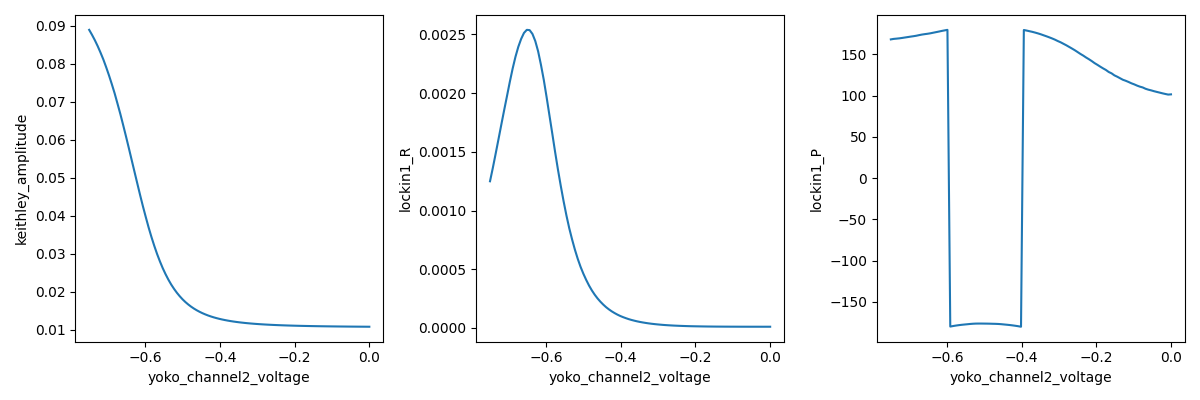

2024-11-25 21:29:24,217 [INFO] Completed in 0h 0m 45s
2024-11-25 21:29:24,217 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data\0\data.tsv.gz


In [13]:
# Run experiment 
START = 0
STOP = -0.750
SAMPLES = 100
INT_TIME = 0.4

# s.watch(delay = INT_TIME, max_duration=10)
setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(vg, setpoints, delay=INT_TIME)

In [22]:
# Look at result metadate for verification 
from sweep.sweep_load import pload1d

data = pload1d(datapath, 0)
Gout_R = data[Gout.R.full_name]
Vgs = data[vg.full_name]

dc_bias = Vgs[np.argmax(Gout_R)]

In [23]:
vg(dc_bias)

In [26]:
Vexc.voltage(0)
Vref.voltage(200)

In [30]:
acdac.frequency(50000)

In [31]:
acdac.print_readable_snapshot()

acdac:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': 'BARRERA', 'model': 'ACDAC02', 'serial': 'AD9106', ...
display_mode :	REMOTE 
 rror        :	0 - No Error
frequency    :	50000 (Hz)
timeout      :	5 (s)
acdac_ch1:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch2:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	200 (mV)
acdac_ch3:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch4:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	400 (mV)


In [39]:
## Balancing arguments
FREQ = 50000
DELTA = (180, 180)
INITIAL = (10, 10)
Cstand = 1  # pF
DRIVE = 100

In [40]:
balancer = Balancer(acdac.ch1, acdac.ch4, acdac.ch2, Gout, acdac.frequency) # ch1 = control, ch4 = reference, ch2 = drive

In [70]:
balancer.excite(DRIVE, 400, FREQ)

In [72]:
null_voltages = balancer.balance(INITIAL, DELTA, null=True)
c_meas = balancer.calculate_capacitance(Cstand)
print(f"null voltages = {null_voltages}")
print(f"Balance Point Capacitance: {c_meas} nF")

Kr1, Kr2 = (np.float64(-0.00011303940760388887), np.float64(7.811134611111095e-06))
Kc1, Kc2 = (np.float64(-7.778048901000002e-06), np.float64(-0.00011321617421333333))
P = 0.9952751329066631
null voltages = (np.float64(250.05370333528106), np.float64(10.708991412737022))
Balance Point Capacitance: 2.5005370333528107 nF


In [73]:
acdac.print_readable_snapshot()

acdac:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': 'BARRERA', 'model': 'ACDAC02', 'serial': 'AD9106', ...
display_mode :	FOCUS1 
 rror        :	0 - No Error
frequency    :	50000 (Hz)
timeout      :	5 (s)
acdac_ch1:
	parameter value
--------------------------------------------------------------------------------
phase   :	177.55 (deg)
voltage :	250.28 (mV)
acdac_ch2:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	100 (mV)
acdac_ch3:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch4:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	400 (mV)


In [51]:
acdac.display_mode("NORMAL")

In [53]:
acdac.ch1.phase(180)
acdac.ch1.voltage(0)

In [58]:
acdac.ch1.voltage(8)
acdac.ch1.phase(45)

In [59]:
acdac.display_mode("FOCUS1")

In [60]:
paramp(vg)

In [61]:
paramp(vdd)

In [ ]:
# sets = np.linspace(0, 400, 40)
# curr_min = np.inf 
# for setx in sets:
#     acdac.ch2.voltage(setx)
#     sleep(0.5)
#     curr_min = min(curr_min, Gout.P())

# print(curr_min)

In [65]:
vdd(0.1)
vg(dc_bias)

In [63]:
paramp(vg)

In [64]:
paramp(vdd)

In [66]:
acdac.ch2.voltage(100)
acdac.ch1.voltage(0)
acdac.ch1.phase(0)
acdac.ch2.phase(0)

In [67]:
acdac.ch2.voltage(0)